# About:
- this notebook:
    - investigates the effect of adding engineered features from featuretools
- insight:
    1. the **engineered features did not yield gains**. 
    2. **Simple fit predict evaluate is not a reliable way to extract engineered features by featuretools**

### prepare dataset

In [4]:
dataset = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\cleaned_train_set.csv")
engineered_features = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\train engineered_feature 0.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
label_colnames = ['h1n1_vaccine', 'seasonal_vaccine']
original_colnames = [col for col in dataset.columns if col not in label_colnames and col!="respondent_id"]
engineered_colnames = ["hhs_geo_region.SKEW(Vaccine.household_children)", "employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)"]

In [10]:
X = engineered_features.merge(dataset).set_index("respondent_id")[engineered_colnames+original_colnames]
y = dataset[label_colnames[0]]
X.head()

,hhs_geo_region.SKEW(Vaccine.household_children),employment_industry.PERCENT_TRUE(Vaccine.rent_or_own),h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.445465,0.228432,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1.477455,0.280617,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,1,0,0,1,1,1,1,1,1
2,1.568201,0.476099,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,1,2,1,2,2
3,1.422831,0.228432,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,3,2,0,0
4,1.568201,0.155211,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,1,1,0,1,2,1,3,3


### instantiate models: CatBoostClassifier,XGBClassifier,LGBMClassifier,VotingClassifier,StackingClassifier

In [45]:
from catboost import CatBoostClassifier
param = {
    "learning_rate" : 0.01,
    "iterations" :  3000,
    'depth': 4, 
    'rsm': 0.2680717988907101, 
    'l2_leaf_reg': 5.087316180296697, 
    'auto_class_weights': 'Balanced',
    "loss_function" : "Logloss",
    "verbose":False,
    "task_type" : "CPU",
    "eval_metric":"AUC"
}
cb = CatBoostClassifier()
cb.set_params(**param)

In [46]:
from xgboost import XGBClassifier
param = {
    "n_estimators" : 1560,
    'learning_rate': 0.012906144911477856,
    'max_depth': 5,
    'reg_alpha': 5,
    'reg_lambda': 0,
    'min_child_weight': 2,
    'gamma': 0,
    'colsample_bytree': 0.23,
    'subsample': 0.98,
    "use_label_encoder" :False
    'eval_metric': 'auc'}
xgb = XGBClassifier()
xgb.set_params(**param)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.23, eval_metric='auc',
              gamma=0, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.012906144911477856,
              max_delta_step=None, max_depth=5, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=1560, n_jobs=None,
              num_parallel_tree=None, random_state=None, reg_alpha=5,
              reg_lambda=0, scale_pos_weight=None, subsample=0.98,
              tree_method=None, validate_parameters=None, verbosity=None)

In [48]:
from lightgbm import LGBMClassifier
param = {
"learning_rate":0.05 ,
"max_depth" : 4,
"colsample_bytree" :0.8,
"subsample" :0.8,
#'objective': 'binary',
"metric" :'auc',
"n_estimators" : 1000
}
lgb = LGBMClassifier().set_params(**param)
lgb.set_params(**param)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=4,
               metric='auc', n_estimators=1000, subsample=0.8)

In [49]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators = [("cb",cb),("xgb",xgb),("lgb",lgb)],
                      voting = "soft",            
                      weights = None ,             # take equal weights
                      n_jobs = -1)

In [50]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
final_estimator = LogisticRegression()
sc = StackingClassifier(estimators = [("cb",cb),("xgb",xgb),("lgb",lgb)],
                        final_estimator = final_estimator,
                        stack_method = "predict_proba" ,          # predict_proba is called on the base estimators as input for final estimator
                        n_jobs = -1)

### benchmark - evaluate on original dataset

In [51]:
score_board = {}

In [59]:
from sklearn.model_selection import cross_val_score
for model_name, model in [("cb",cb),("xgb",xgb),("lgb",lgb),("vc",vc),("sc",sc)]:
    score_board[model_name] = cross_val_score(model,X[original_colnames],y,cv= 3,n_jobs = -1,scoring = "roc_auc").mean()

### evaluate on original dataset+
- plus "hhs_geo_region.SKEW(Vaccine.household_children)" 

In [71]:
from sklearn.model_selection import cross_val_score
for model_name, model in [("cb",cb),("xgb",xgb),("lgb",lgb),("vc",vc),("sc",sc)]:
    score_board[f"{model_name}+"] = cross_val_score(model,X[original_colnames+[engineered_colnames[0]]],y,cv= 3,n_jobs = -1,scoring = "roc_auc").mean()

### evaluate on original dataset ++  
-  plus "hhs_geo_region.SKEW(Vaccine.household_children)", "employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)"

In [62]:
from sklearn.model_selection import cross_val_score
for model_name, model in [("cb",cb),("xgb",xgb),("lgb",lgb),("vc",vc),("sc",sc)]:
    score_board[f"{model_name}++"] = cross_val_score(model,X[original_colnames+engineered_colnames],y,cv= 3,n_jobs = -1,scoring = "roc_auc").mean()

# Results

In [112]:
score_board

{'cb': 0.868522182594473,
 'xgb': 0.8693224322276961,
 'lgb': 0.8614527466623024,
 'vc': 0.8688225758961922,
 'sc': 0.8692986678606819,
 'cb++': 0.8685257787592887,
 'xgb++': 0.8689654021407115,
 'lgb++': 0.8602772638958772,
 'vc++': 0.8684850036646706,
 'sc++': 0.8691684444784555,
 'cb+': 0.868461638214467,
 'xgb+': 0.8691336383256161,
 'lgb+': 0.8610529075152561,
 'vc+': 0.868704786787761,
 'sc+': 0.8691878635903908}

### Result- adding the engineered featiure always worsened performance
- hypothesis: 
    - when the features were selected using simple fit and predict without cross validation
    - the marginal gains seen before only applied to that particular train test split

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

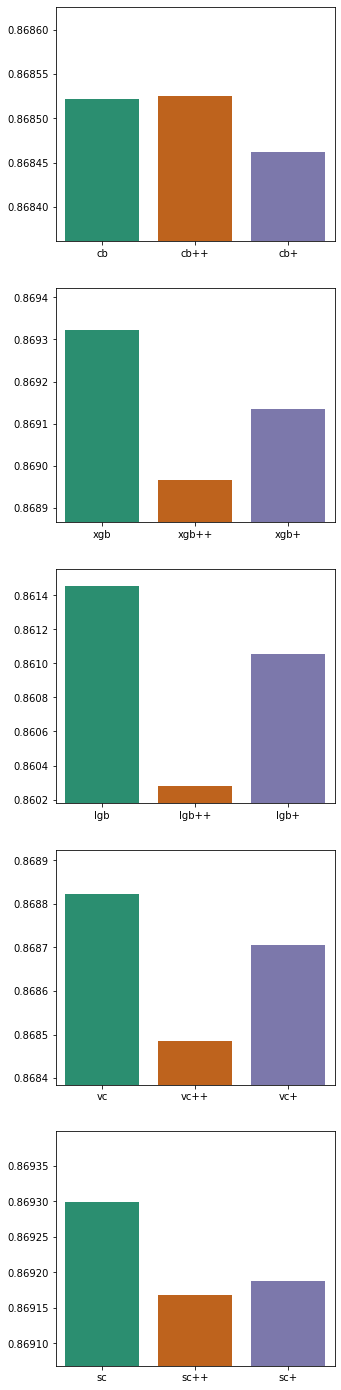

In [102]:
f, axes = plt.subplots(5, 1,figsize = (5,25))
for i,model_name in enumerate(["cb","xgb","lgb","vc","sc"]):
    temp = {k:score for k,score in score_board.items() if model_name in k}
    sns.barplot(data = pd.DataFrame(temp,index= ["CV"]),palette = "Dark2",ax = axes[i]).set(ylim = (min(temp.values())-0.0001,max(temp.values())+0.0001))

<IPython.core.display.Javascript object>

<AxesSubplot:>

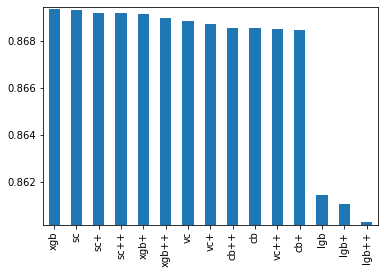

In [111]:
pd.Series(score_board).sort_values(ascending = False).plot(kind='bar',ylim = (min(score_board.values())-0.0001,max(score_board.values())+0.0001))